<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-network" data-toc-modified-id="Load-network-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Load network</a></span></li><li><span><a href="#Load-cases" data-toc-modified-id="Load-cases-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Load cases</a></span></li></ul></li></ul></li></ul></div>

# Learning Generation - Part 1

We first start without line capacity constraints and fit a single training example.

In [1]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Distributions, Random  
using Plots
using LinearAlgebra

using Revise
using CarbonNetworks

# Load data

### Load network

In [2]:
DATAPATH = "/Users/degleris/Data/carbon_networks/"
A, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH; num_generators=1)
n = length(gmax)
m = length(pmax)

# Remove infinite capacities
# pmax[pmax .== Inf] .= 3*maximum(gmax)
pmax .= 2*maximum(gmax)

normalization = mean(gmax)
gmax /= normalization
pmax /= normalization

@show n, m;

agg_nodes, B = create_generation_map(nodes);

(n, m) = (380, 471)


### Load cases

In [28]:
file_names = joinpath.(joinpath(DATAPATH, "TRAIN"), readdir(joinpath(DATAPATH, "TRAIN")))

cases = []
for file in file_names   
    d, g, case = load_case(file, agg_nodes, B, nodes)
    d = d/normalization
    g = g/normalization
    push!(cases, (d=d, g=g, case=case))
end

train_size = 100
test_size = 100

train_cases = cases[1:train_size]
test_cases = cases[train_size+1:train_size+test_size];

# Initialize

In [42]:
# Seeds that seem to work: 706
seed = 706  # rand(1:1_000)
Random.seed!(seed)

# Initialize estimated costs
f̂q = max.(1.0, 3 .+ randn(n)) 
f̂l = max.(1.0, 3 .+ randn(n)) 

train_loss_hist = []
test_loss_hist = []
grad_hist = []

Any[]

# Fit

In [78]:
# Algorithm parameters
step_size = 50.0
max_iter = 16_000
batch_size = 8
test_batch_size = 1

1

In [79]:
@time for iter in 1:max_iter
    if mod(iter, 100) == 0
        print("$(iter)-")
    end
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, dfq, dfl = stochastic_loss_and_grad(f̂q, f̂l, B, train_cases, pmax, gmax, A, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, dfq)
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _, _ = stochastic_loss_and_grad(f̂q, f̂l, B, test_cases, pmax, gmax, A, sample)
    
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    ηq = 0.01 * min(norm(dfq), step_size)
    f̂q = max.(f̂q - ηq*(dfq/norm(dfq)), 0)
    
    ηl = 0.01 * min(norm(dfl), step_size)
    f̂l = max.(f̂l - ηl*(dfl/norm(dfl)), 0)
end

@show minimum(train_loss_hist)
println("Completed $(max_iter) iterations.")

100-200-300-400-500-600-700-800-900-1000-1100-1200-1300-1400-1500-1600-1700-1800-1900-2000-2100-2200-2300-2400-2500-2600-2700-2800-2900-3000-3100-3200-3300-3400-3500-3600-3700-3800-3900-4000-4100-4200-4300-4400-4500-4600-4700-4800-4900-5000-5100-5200-5300-5400-5500-5600-5700-5800-5900-6000-6100-6200-6300-6400-6500-6600-6700-6800-6900-7000-7100-7200-7300-7400-7500-7600-7700-7800-7900-8000-8100-8200-8300-8400-8500-8600-8700-8800-8900-9000-9100-9200-9300-9400-9500-9600-9700-9800-9900-10000-10100-10200-10300-10400-10500-10600-10700-10800-10900-11000-11100-11200-11300-11400-11500-11600-11700-11800-11900-12000-12100-12200-12300-12400-12500-12600-12700-12800-12900-13000-13100-13200-13300-13400-13500-13600-13700-13800-13900-14000-14100-14200-14300-14400-14500-14600-14700-14800-14900-15000-15100-15200-15300-15400-15500-15600-15700-15800-15900-16000-5530.880830 seconds (5.01 G allocations: 2.639 TiB, 2.59% gc time)
minimum(train_loss_hist) = 0.20685183307383517
Completed 16000 iterations.


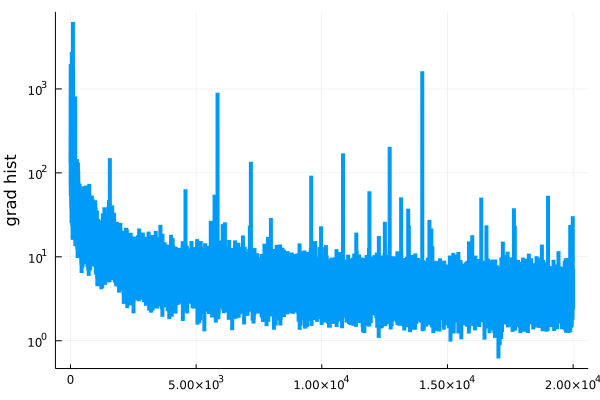

In [101]:
theme(:default, lw=4, label=nothing)

smallest = x -> [minimum(x[1:k]) for k in 1:length(x)]

# plot(
     plot(train_loss_hist, ylabel="train", size=(800, 400), yscale=:log10, xscale=:log10)
     plot(norm.(grad_hist), ylabel="grad hist", yscale=:log10)
#     plot(test_loss_hist, ylabel="test", yscale=:log10),
#     layout=(2, 1)
# )

In [88]:
# Compute error
train_rel_error = []
for case in train_cases
    ĝ, opf, params = CarbonNetworks.solvePMP(f̂q, f̂l, case, pmax, gmax, A)
    push!(train_rel_error, norm(case.g - B*ĝ) / norm(case.g))
end

test_rel_error = []
for case in test_cases
    ĝ, opf, params = CarbonNetworks.solvePMP(f̂q, f̂l, case, pmax, gmax, A)
    push!(test_rel_error, norm(case.g - B*ĝ) / norm(case.g))
end

@show mean(train_rel_error)
@show mean(test_rel_error)

mean(train_rel_error) = 0.31818139601083606
mean(test_rel_error) = 0.4239676637673927


0.4239676637673927

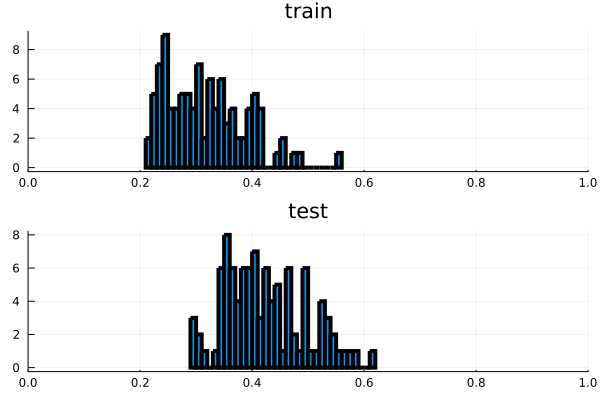

In [98]:
plt1 = histogram(train_rel_error, nbins=50, xlim=(0, 1.0), title="train")
plt2 = histogram(test_rel_error, nbins=50, xlim=(0, 1.0), title="test")

plot(plt1, plt2, layout=(2, 1))

sum(B * ĝ) = 196.3597664569953
sum(case.g) = 196.35976647344904


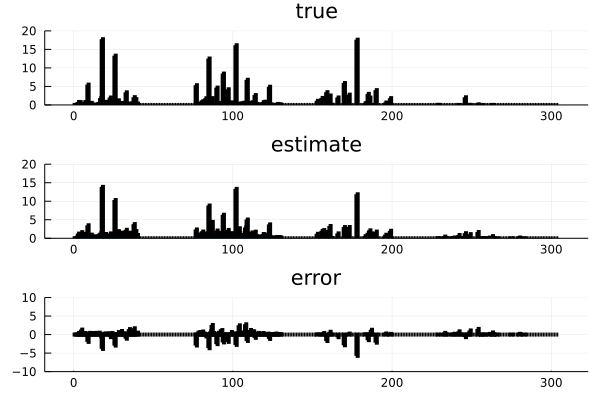

In [102]:
case = train_cases[22]
ĝ, opf, params = CarbonNetworks.solvePMP(f̂q, f̂l, case, pmax, gmax, A)

@show sum(B*ĝ)
@show sum(case.g)

plot(
    bar(case.g, ylim=(0, 20), title="true"), 
    bar(B*ĝ, ylim=(0, 20), title="estimate"), 
    bar(B*ĝ - case.g, ylim=(-10, 10), title="error"), 
    layout=(3, 1)
)

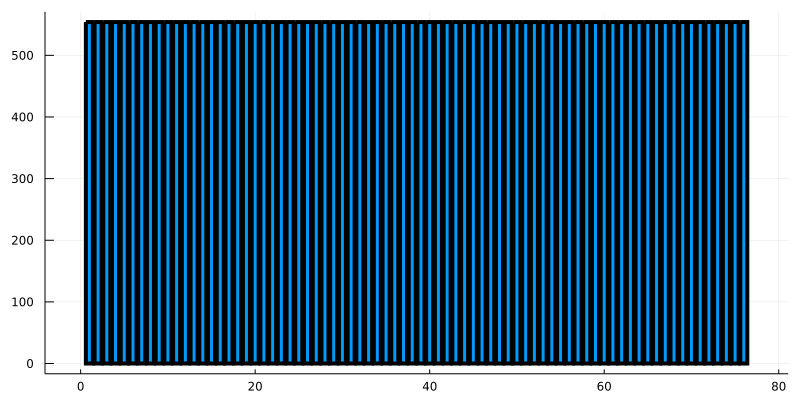

In [114]:
∇C = zeros(kkt_dims(n, m))
∇C[1:n] .= f  # <-- Carbon costs

primary_nodes = findall(x -> x[3] == "DEMAND", nodes)
mefs = sensitivity_demand(opf, ∇C, params...)[primary_nodes]

bar(mefs, size=(800, 400))

In [ ]:
@gif for iter in 1:10_000
    iter = ceil(Int, iter / 5)
    bar(grad_hist[iter], ylim=(-100, 100), title="iter $iter")
end